#### IMPORTAR LIBRERÍAS

In [46]:
# Trabajo de Final de Grado, Grado en Física, 2022-2023
# Redes Neuronales Hamiltonianas
# Péndulo simple sin aproximar
# Francisco Jesús Frías Tenza

import warnings

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.integrate import solve_ivp

import autograd
import autograd.numpy as np

import argparse
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf

import pandas as pd

In [47]:
global system_config
system_config = {"m": 1,
                 "l": 2,
                 "g": 10}     

TASA_DE_APRENDIZAJE = 0.005       
CICLOS = 2500               
DIM_OCULTA = 200         

#### Definición del Hamiltoniano
Definimos el hamiltoniano del sistema y la función de Raylegth para la pérdida de energía

In [48]:
def IdealPendulumHam(coords: np.ndarray) -> float:
    """
    Esta función es el hamiltoniano analítico del sistema de un péndulo no ideal

    INPUT
    -----
    coords
        array con q, p para cada cuerpo. Las filas son las coordenadas (qx, qy, qz, px, py, pz) y las columnas los cuerpos.
    system_config
        diccionario con los parámetros del sistema, masa, constante elástica, etc.
    """
    q, p = np.split(coords, 2)
    m, l, g = system_config["m"], system_config['l'], system_config['g']
    return m*g*l * (1 - np.cos(q)) +  p**2 / (2*m*l**2)

In [49]:
def PendulumRayleighFunc(coords: np.ndarray) -> float:
    """
    Esta función es la función de Rayleght para el péndulo simple

    INPUT
    -----
    coords
        array con q, p para cada cuerpo. Las filas son las coordenadas (qx, qy, qz, px, py, pz) y las columnas los cuerpos.
    system_config
        diccionario con los parámetros del sistema, masa, constante elástica, etc.
    """
    q, p = np.split(coords,2)
    m, l, g = system_config["m"], system_config['l'], system_config['g']
    return 0.5 * system_config['kappa'] * ( p**2 / (m**2 * l**2) ) # l**2 qdot**2 derivada coord generalizada = p**2 / m**2*l**2


#### Gradiente simplético y gradiente simplético no ideal
El gradiente simplético no ideal tiene en cuenta la pérdida de energía a través de la función de Rayleght

In [50]:
def SympGrad(t, coords):
    """
    gradiente simpléctico
    """
    dcoords = autograd.grad(IdealPendulumHam)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def NonIdealSympGrad(t, coords):
    """
    gradiente simpléctico no ideal
    """   
    m, l, g = system_config["m"], system_config['l'], system_config['g']
    dcoords = autograd.grad(IdealPendulumHam)(coords)
    # Annadimos la funcion de Raylegth
    S = np.array([[0,  1],
                  [-1, 0]]) @ dcoords - np.array([0, autograd.grad(PendulumRayleighFunc)(coords)[1] * m * l**2]).T
    return S

#### Cómputo de la trayectoria y generación del set de datos

In [51]:
def trayectoria(t_final: float, t_inicio: float, dt: float, y0: np.ndarray, ruido=0) -> np.ndarray:
    r"""
    Tomando las ecuaciones de Hamilton $\frac{dq}{dt} = \frac{dH}{dp}$ y $\frac{dq}{dt} = \frac{dH}{dp}$
    vamos a interpretarlas como un sistema de ecuaciones diferenciales del tipo dy/dt = f(x,y,t) sobre las 
    que hay que integrar numericamente. Emplearemos el metodo Runge-Kutta de orden 4 para obtener q(t+dt), p(d+dt).
    h es salto temporal, que va a ser el mismo para las coordenadas.
    """
    N = int((t_final - t_inicio) / dt)
    t_space = np.linspace(t_inicio, t_final, N)

    solu = solve_ivp(fun=SympGrad, t_span=(t_inicio, t_final), y0=y0, t_eval=t_space, atol=1e-5, rtol=1e-5)
    y = solu.y
    q, p = y[0,:], y[1,:]
    coords = y.copy()
    dcoords_dt = np.empty((2, N))
    for i in range(0, N):
        dcoords_dt[:,i] = SympGrad(t=t_space[i], coords=coords[:,i])
    dqdt, dpdt = dcoords_dt[0,:], dcoords_dt[1,:]

        ## Annadimos ruido a los datos
    q += np.random.randn(*q.shape)*ruido
    p += np.random.randn(*p.shape)*ruido

    return q, p, dqdt, dpdt, t_space, dt, y0

In [52]:
def generate_dataset(semilla=1, muestras=50, ruido=0.1, **kwargs):

    # muestreamos inpus y outputs aleatorios
    np.random.seed(semilla)
    q_data, p_data, dqdt_data, dpdt_data = [], [], [], []
    t_final = np.random.uniform(20, 50)
    for _ in range(muestras):
        y0 = np.random.rand(2, 1) * 10 # generar semillas iniciales aleatorias
        #print(t_final)
        q, p, dq, dp, t_space, *args = trayectoria(t_final=t_final, t_inicio=0, dt = 0.1, y0=y0.T[0], ruido=ruido)
        #print(q, p, dq, dp)
        #print(q.shape if _ == 1 else pass)
        q_data.append(q); p_data.append(p)
        dqdt_data.append(dq); dpdt_data.append(dp)
    
    split_data = {
        "dq": np.concatenate(dqdt_data, axis=-1), # Y set
        "dp": np.concatenate(dpdt_data, axis=-1),
        "q": np.concatenate(q_data, axis=-1),  # X set
        "p": np.concatenate(p_data, axis=-1),
    }

    df = pd.DataFrame.from_dict(split_data, orient='columns')

    return df


#### Funciones para plots

In [53]:
def get_field(xmin=-6, xmax=6, ymin=-6, ymax=6, gridsize=20):
    # meshgrid to get vector field
    y_grid, x_grid = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    dxdt = np.empty_like(y_grid)
    dydt = np.empty_like(x_grid)
    for j, y in enumerate(np.linspace(ymin, ymax, gridsize)):
        for i, x in enumerate(np.linspace(xmin, xmax, gridsize)):
            aux = SympGrad(t=None, coords=np.array([x,y]).T)
            dxdt[i,j], dydt[i,j] = aux[0], aux[1] 
    return x_grid, y_grid, dxdt, dydt

def plot_figures_compare(q, p, dqdt, dpdt, t_space, dt, y0):

    x_grid, y_grid, dxdt, dydt = get_field(gridsize=15)

    N = len(q)
    color = mlp.colormaps['Reds']
    color_aux = mlp.colormaps['Blues']
    color_ranges = np.sqrt(p[::12]**2/2 + q[::12]**2/2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(w=11, h=11)
    fig.tight_layout(pad=6.5)
    ax1_twinx = ax1.twinx()
    ax3_twinx = ax3.twinx()

    ax1.plot(t_space, q, "r-", label=r"$q(t)$")
    ax1.set_ylabel('Posición (m)', )
    ax1.xaxis.label.set_color('black')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(colors='red', axis='y')

    ax1_twinx.plot(t_space, p, "b-", label=r"$p(t)$")  
    ax1.set_xlabel('Tiempo (s)')
    ax1_twinx.set_ylabel('Velocidad (m/s)')
    ax1_twinx.xaxis.label.set_color('black')
    ax1_twinx.yaxis.label.set_color('blue')
    ax1_twinx.tick_params(colors='blue', axis='y')
    ax1.legend(bbox_to_anchor=(0.75, 1.2))
    ax1_twinx.legend(bbox_to_anchor=(0.95, 1.2))

    #ax2.scatter(q[::10], p[::10], c=np.sqrt(p[::10]**2 + q[::10]**2), cmap=color, label="Espacio de Fase")
    ax2.quiver(x_grid, y_grid, dxdt, dydt, cmap='bwr', label="Espacio de fases")
    ax2.set_xlabel("q")
    ax2.set_ylabel("p")
    ax2.legend(bbox_to_anchor=(0.95, 1.15))
    #ax2.set_xlim((-6, 6))
    #ax2.set_ylim((-6, 6))

    w = np.sqrt(system_config['g'] / system_config['l'])
    ax3.plot(t_space, y0[0]*np.cos(w*t_space), color="blue", linestyle="dashed", label=r"$q(t)$ solucion analítica")
    # ptheta = m l^2 dot{\theta}
    ax3_twinx.plot(t_space, -system_config['m']*system_config['l']**2*w*y0[0]*np.sin(w*t_space), color="cyan", linestyle="dashed", label=r"$p(t)$ solucion analítica")
    ax3.plot(t_space, q, "r-", label=r"$q(t)$ solución numérica")
    ax3_twinx.plot(t_space, p, color="orange", label=r"$p(t)$ solución numérica")  
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
            ncol=3, fancybox=True, shadow=False)    
    ax3_twinx.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=3, fancybox=True, shadow=False)
    ax3.set_ylabel('Posición (m)', )
    #ax3.tick_params(colors='red', axis='y')
    ax3.set_xlabel('Tiempo (s)')
    ax3_twinx.set_ylabel('Velocidad (m/s)')
    #ax3_twinx.tick_params(colors='blue', axis='y')

    ax4.scatter(q[::12], p[::12], s=5, c=color_ranges, cmap=color, 
                norm=colors.CenteredNorm(vcenter=color_ranges.max()/2,
                                         halfrange=color_ranges.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
                label="Resultado numérico")
    #ax4.scatter(np.cos(t_space[::10]), -np.sin(t_space[::10]), s=1.5, c=color_ranges, cmap=color_aux, 
    #            norm=colors.CenteredNorm(vcenter=color_ranges.max()/2,
    #                                     halfrange=color_ranges.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
    #            label="Resultado analítico")
    #ax4.quiver(x_grid, y_grid, dxdt, dydt, cmap='PRGn', color=(.5,.5,.5), alpha=0.5)
    ax4.set_xlabel("q")
    ax4.legend(loc='upper right')
    ax4.set_ylabel("p")
    #ax4.set_xlim((-10, 6))
    #ax4.set_ylim((-6, 6))
    
    
    #ax4.scatter(q[::2], p[::2], c=np.sqrt(p**2 + q**2), label="Espacio de Fase")
    
    fig.savefig(r".\img\sim_pendulum_{}_{}".format(int(q[0]), int(p[0])))

#### Definición de los modelos

Red Neuronal Hamiltoniana HNN

In [54]:
class HNN(tf.Module):
  
  def __init__(self, dim_entrada, dim_oculta, name=None):
    super().__init__(name=name)
    self.dim_entrada = dim_entrada
    self.dim_oculta = dim_oculta
    self.capa1 = tf.keras.layers.InputLayer(input_shape=self.dim_entrada) # Input layer
    self.capa2 = tf.keras.layers.Dense(units=self.dim_oculta, activation='tanh')
    #self.capa3 = tf.keras.layers.Dense(units=self.dim_oculta, activation='tanh') 
    # Si se busca crear más capas, ha de copiarse y pegar el siguiente código
    # self.capa_n = tf.keras.layers.Dense(units=dim_oculta, activation='tanh') # donde "_n" es u numero natural
    self.capa4 = tf.keras.layers.Dense(1) # Output layer
    O = np.zeros((dim_entrada//2, dim_entrada//2))
    I = np.identity(dim_entrada//2)
    R_90 = np.concatenate([np.concatenate((O, I), axis=1), np.concatenate((-I, O), axis=1)], axis=0)
    self.R_90 = tf.constant(R_90, dtype='double')

  @tf.Module.with_name_scope
  def __call__(self, x):
    y = self.capa1(x)
    y = self.capa2(y)
    #y = self.capa3(y)
    y = self.capa4(y)
    return y
  
  def compute_symplectic_gradient(self, x):
    with tf.GradientTape() as tape:
      y = self.capa1(x)
      y = self.capa2(y)
      #y = self.capa3(y)
      y = self.capa4(y)
    y = tape.gradient(y, x)
    y = y @ np.linalg.inv(self.R_90)
    return y
  
  def entrenar_HNN(self, data, tasa_de_aprendizaje = TASA_DE_APRENDIZAJE, ciclos = CICLOS):
    warnings.filterwarnings('ignore')
    loss_array = np.zeros(ciclos+1)
    # Tomamos el algoritmo Adam para optimización
    adam_aldoritmo = tf.keras.optimizers.Adam(learning_rate=tasa_de_aprendizaje)
    # Declaramos la función de coste
    funcion_coste_L2 = tf.keras.losses.MeanSquaredError()
    ciclo = 0
    while ciclo <= ciclos:
        with tf.GradientTape() as tape_coste: # Este es el gradiente de la función de coste
            tape_coste.watch(self.trainable_variables) # Esto nos permite 'vigilar' las variables de TensorFlow
            y_train_keys = [key for key in data.columns if 'd' in key]
            y_test_keys = [key for key in data.columns if 'd' not in key]
            #print(y_train_keys, y_test_keys)
            y_pred = self.compute_symplectic_gradient(tf.Variable(tf.stack(data[y_test_keys]))) # SympGrad del Hamiltoniano
            y_real = tf.Variable(tf.stack(data[y_train_keys]))
            loss = funcion_coste_L2(y_pred=y_pred, y_true=y_real) # Evaluación de la función de coste
        # Creamos el gradiente
        gradiente_funcion_coste_L2 = tape_coste.gradient(loss, self.trainable_variables)
        # El siguiente paso es opcional, usamos esto para agilizar el entrenamiento
        adam_aldoritmo.apply_gradients(zip(gradiente_funcion_coste_L2, self.trainable_variables))
        print(ciclo, loss)
        loss_array[ciclo] = loss
        ciclo += 1
    warnings.resetwarnings()

    return loss_array
  
  def integrar_HNN(self, **kwargs):
    return solve_ivp(fun=lambda t, x: self.compute_symplectic_gradient(tf.Variable(tf.reshape(x, (1, self.dim_entrada)), dtype='double')), **kwargs)


#### Entrenamiento de la red neuronal

In [56]:
hnn_modelo = HNN(dim_entrada=2, dim_oculta=DIM_OCULTA)
loss = hnn_modelo.entrenar_HNN(data=generate_dataset(), tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

0 tf.Tensor(97.00851374637178, shape=(), dtype=float64)
1 tf.Tensor(96.86655364001695, shape=(), dtype=float64)
2 tf.Tensor(96.7344890239774, shape=(), dtype=float64)
3 tf.Tensor(96.61235186980807, shape=(), dtype=float64)
4 tf.Tensor(96.49949529285914, shape=(), dtype=float64)
5 tf.Tensor(96.39402916737538, shape=(), dtype=float64)
6 tf.Tensor(96.29425466054103, shape=(), dtype=float64)
7 tf.Tensor(96.19923221539261, shape=(), dtype=float64)
8 tf.Tensor(96.10852046325913, shape=(), dtype=float64)
9 tf.Tensor(96.02162353601175, shape=(), dtype=float64)
10 tf.Tensor(95.93757175778313, shape=(), dtype=float64)
11 tf.Tensor(95.855659608126, shape=(), dtype=float64)
12 tf.Tensor(95.7754363651972, shape=(), dtype=float64)
13 tf.Tensor(95.69665549939752, shape=(), dtype=float64)
14 tf.Tensor(95.61917370600024, shape=(), dtype=float64)
15 tf.Tensor(95.54264084001878, shape=(), dtype=float64)
16 tf.Tensor(95.46627928866253, shape=(), dtype=float64)
17 tf.Tensor(95.38935416238483, shape=(), dty

#### Demostración

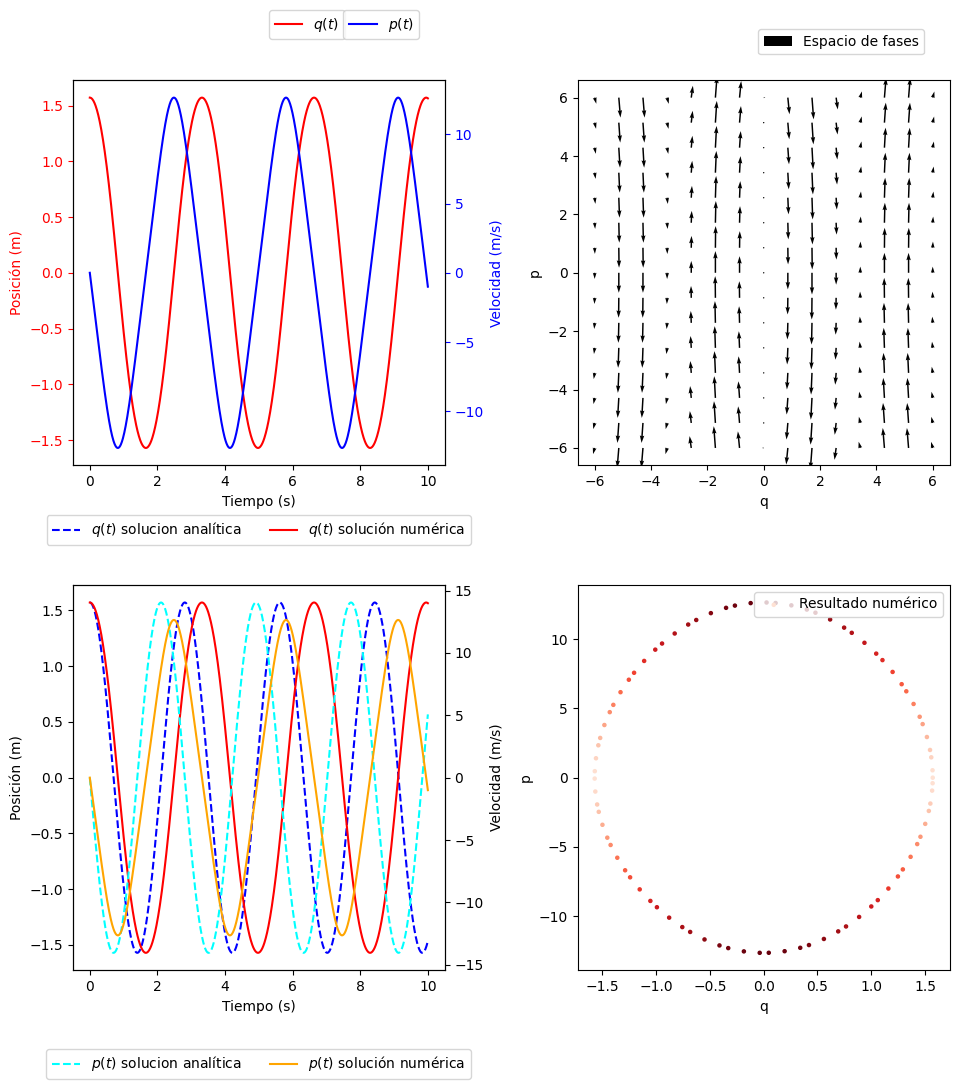

In [57]:
plot_figures_compare(*trayectoria(t_final=10, t_inicio=0, dt=0.01, y0=np.array([np.pi/2,0])))

#### Análisis

In [58]:
t_span = [0,20]
t_puntos = 2000
t_eval = np.linspace(t_span[0], t_span[1], t_puntos)
atol = 1e-9; rtol = 1e-9
y0 = np.array([1, 0])
kwargs = {'y0': y0, 't_span': t_span, 't_eval': t_eval, 'rtol': rtol, 'atol': atol}
hnn_trayectoria = hnn_modelo.integrar_HNN(**kwargs)

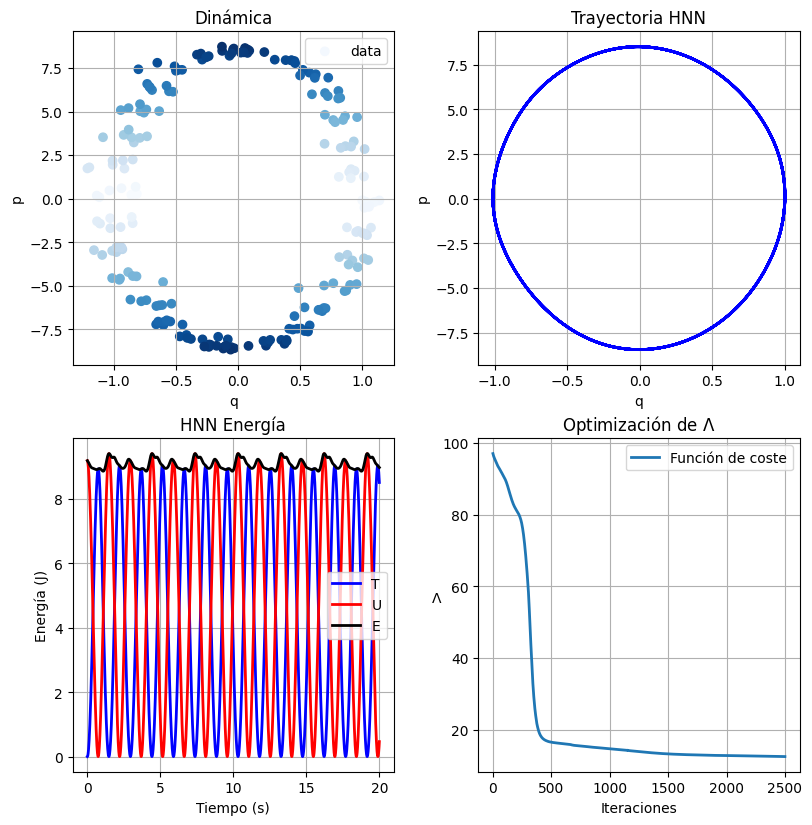

In [62]:
def T(p, system_config):
    m = system_config['m']
    l = system_config['l']
    return p**2 / (2*m*l**2)

def U(x, system_config):
    g = system_config['g']
    l = system_config['l']
    m = system_config['m']
    return m * g * l * (1 - np.cos(x))

# m*g*l * (1 - np.cos(q)) +  p**2 / (2*m*l**2)
color = mlp.colormaps['Blues']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(8, 8)
fig.tight_layout(pad=1.1, h_pad=3.2, w_pad=3)

x, y, dx, dy, t, dt, H_values = trayectoria(t_final=20, t_inicio=0, dt=0.01, y0=y0, ruido=0.1)

ax1.scatter(x[::10], y[::10], c=np.sqrt(x[::10]**2 + y[::10]**2), cmap=color, label='data')
ax1.set_xlabel("q", fontsize=10)
ax1.set_ylabel("p", fontsize=10)
ax1.set_title("Dinámica")
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,1], color='b', linewidth=2)    
ax2.set_xlabel("q", fontsize=10)
ax2.set_ylabel("p", fontsize=10)
ax2.set_title("Trayectoria HNN")
ax2.grid()

U_energias = U(hnn_trayectoria['y'].T[:,0], system_config=system_config)
T_energias = T(hnn_trayectoria['y'].T[:,1], system_config=system_config)
E_energias = T_energias + U_energias

ax3.plot(t, T_energias, color='b', linewidth=2, label="T")
ax3.plot(t, U_energias, color='r', linewidth=2, label="U")
ax3.plot(t, E_energias, color='k', linewidth=2, label="E")    
ax3.set_xlabel("Tiempo (s)", fontsize=10)
ax3.set_ylabel("Energía (J)", rotation=90, fontsize=10)
ax3.set_title("HNN Energía")
ax3.legend()
ax3.grid()

ax4.plot(np.arange(len(loss)), loss, linewidth=2, label="Función de coste")    
ax4.set_xlabel("Iteraciones", fontsize=10)
ax4.set_ylabel(r"$\Lambda$", rotation=0, fontsize=10)
ax4.set_title(r"Optimización de $\Lambda$")
ax4.legend()
ax4.grid()

plt.savefig(r".\img\hnn_pred_{}_{}.png".format(int(x[0]), int(y[0])))

#### Guardamos el modelo

In [60]:
#hnn_model.save('./ideal_pendulum.tf', save_format='tf')
#keras.saving.save_model(
#    hnn_model, './ideal_pendulum.tf', overwrite=True, save_format='tf'
#)
#hnn_modelo.save_weights('./ideal_pendulum_weights.h5', save_format='h5')